# Setup

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'2.3.0'

In [3]:
from sklearn.model_selection import train_test_split

data = pd.read_csv('./data_labels_mainData.csv')

train_data_big, test_data_big = train_test_split(data, test_size=0.2, random_state=42)
train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))

# making data set smaller for faster compile

_, train_data = train_test_split(train_data_big, test_size=0.2, random_state=42)
_, test_data = train_test_split(test_data_big, test_size=0.2, random_state=42)
_, val_data = train_test_split(val_data_big, test_size=0.2, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980
Train data : 1188, Val Data: 396, Test Data: 396


In [4]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [5]:
# cellType needs to be string
train_data['cellType'] = train_data['cellType'].astype('str')
val_data['cellType'] = val_data['cellType'].astype('str')

<ipython-input-5-c8097c89ef5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['cellType'] = train_data['cellType'].astype('str')
<ipython-input-5-c8097c89ef5b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_data['cellType'] = val_data['cellType'].astype('str')


# Model


In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1188 validated image filenames belonging to 4 classes.
Found 396 validated image filenames belonging to 4 classes.


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_11 (Lambda)           (None, 27, 27, 1)         0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 25, 25, 32)        320       
_________________________________________________________________
activation_40 (Activation)   (None, 25, 25, 32)        0         
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
activation_41 (Activation)   (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 8, 8, 64)        

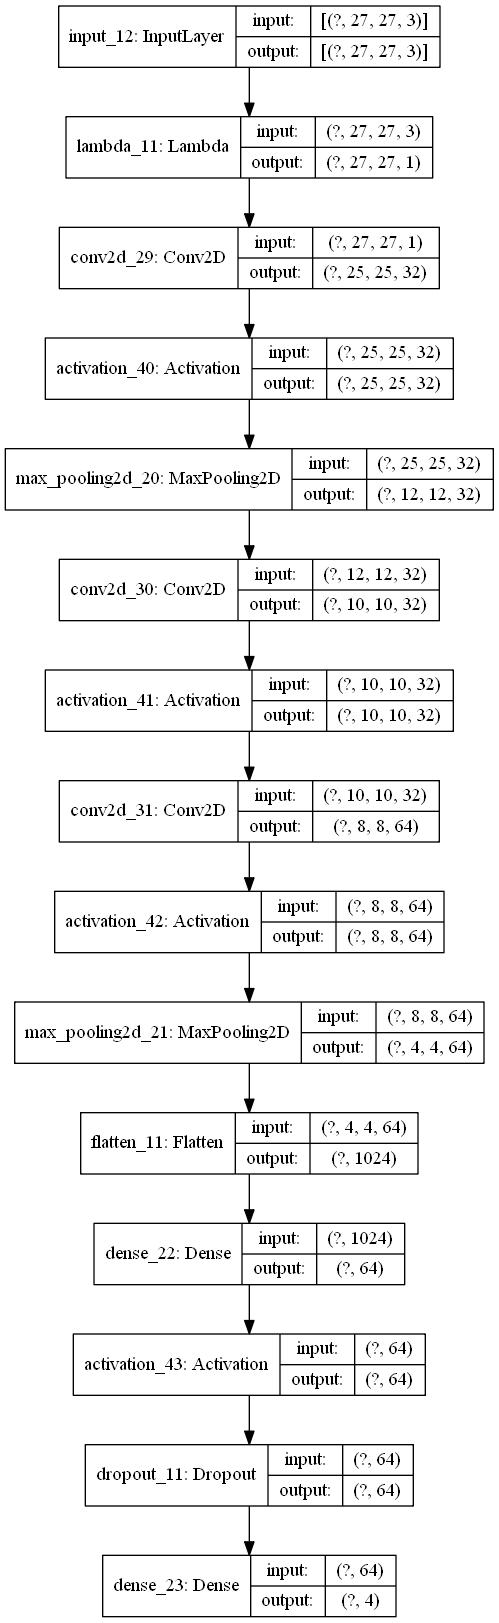

In [24]:
reg_lambda = 0.001
OUTPUT_CLASSES = 4

model_leNet1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
model_leNet1.summary()
tf.keras.utils.plot_model(model_leNet1, show_shapes=True)

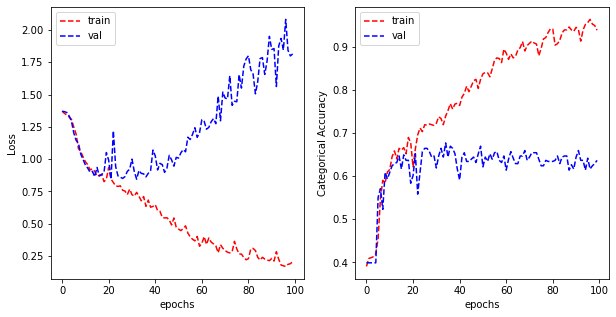

In [25]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet1.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history1 = model_leNet1.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

plot_learning_curve(history1.history['loss'], history1.history['val_loss'], 
                    history1.history['categorical_accuracy'], history1.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

# Tuning using data augmentation

In [35]:
# train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=10)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1188 validated image filenames belonging to 4 classes.
Found 396 validated image filenames belonging to 4 classes.


Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_15 (Lambda)           (None, 27, 27, 1)         0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 25, 25, 32)        320       
_________________________________________________________________
activation_56 (Activation)   (None, 25, 25, 32)        0         
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 10, 10, 32)        9248      
_________________________________________________________________
activation_57 (Activation)   (None, 10, 10, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 64)        

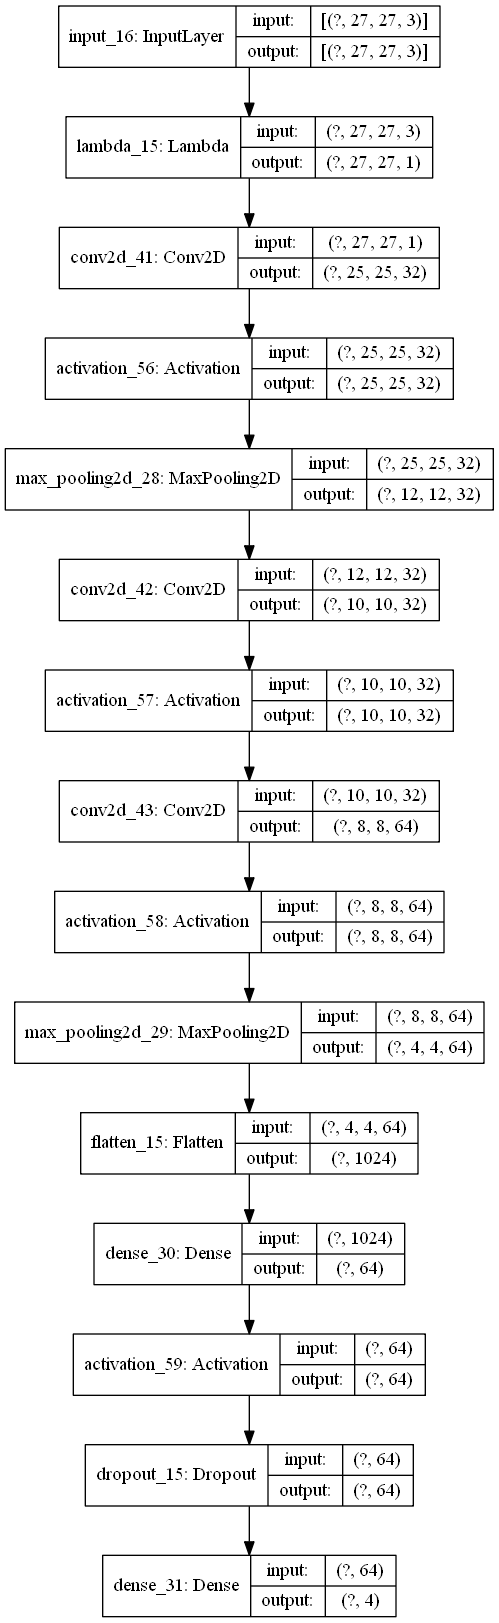

In [36]:
model_leNet2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
model_leNet2.summary()
tf.keras.utils.plot_model(model_leNet2, show_shapes=True)

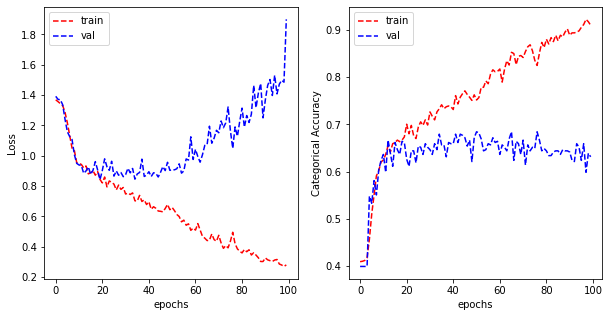

In [37]:
sgd = tf.keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_leNet2.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history2 = model_leNet2.fit_generator(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=100, verbose=0)

plot_learning_curve(history2.history['loss'], history2.history['val_loss'], 
                    history2.history['categorical_accuracy'], history2.history['val_categorical_accuracy'], 
                    metric_name='Categorical Accuracy')

# Testing


In [21]:
# Initialize test generator
test_data['cellType'] = test_data['cellType'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 1
test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_img,test_labels = test_generator.next()

Found 396 validated image filenames belonging to 4 classes.


<ipython-input-21-2cefe04de54d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['cellType'] = test_data['cellType'].astype('str')


In [26]:
model_leNet1.evaluate(test_generator)

396/396 [==============================] - 1s 2ms/step - loss: 1.5742 - categorical_accuracy: 0.6793


[1.574207067489624, 0.6792929172515869]

In [34]:
model_leNet2.evaluate(test_generator)

396/396 [==============================] - 1s 3ms/step - loss: 1.3191 - categorical_accuracy: 0.4242


[1.3190642595291138, 0.42424243688583374]